# Benchmark Modell SPS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.insert(0, '..')
from helper.lazy_regression import TooLazyForRegression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from statsmodels.regression.linear_model import WLS

pd.options.display.max_columns = None

In [2]:
data = pd.read_table('../data/data_sps.txt', sep=' ')
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
feature_cols.remove('start_time')

In [3]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
X,y = data[feature_cols], data['size_mm']
X.head(2)

,packnr,velocity,centroid_frequency_G01,centroid_frequency2_G01,centroid_frequency_G02,centroid_frequency2_G02,centroid_frequency_M01,centroid_frequency2_M01,centroid_frequency_S01,centroid_frequency2_S01,median_freq_G01,median_freq_G02,median_freq_M01,median_freq_S01,flash_ind_G01,flash_ind_G02,flash_ind_M01,flash_ind_S01,cv_G01,cv_G02,cv_M01,cv_S01,iqa_G01,iqa_G02,iqa_M01,iqa_S01,mab_G01,mab_G02,mab_M01,mab_S01,imp_G01,imp_G02,imp_M01,imp_S01,len_G01,len_G02,len_M01,len_S01
0,15,3.2,5424.572186,1520.781662,4013.797724,2931.354363,8652.790926,7182.425705,8379.295548,6547.882196,3485.455767,3055.208472,7244.649105,6737.795587,0.007034,0.006666,0.005020,0.006973,1.766690,1.600798,1.271133,0.985044,4.766670e-10,3.898390e-09,0.000039,0.028844,0.001161,0.004824,0.579816,10,0,0,0,0,74,74,74,74
1,128,2.5,2531.546238,2452.230598,2513.989739,2317.553615,5611.165495,5714.516900,4529.183358,3008.921229,2479.874016,2356.206594,5636.518996,3020.389124,0.011831,0.007217,0.008924,0.024140,3.013262,2.634793,1.690594,2.014689,3.733215e-04,1.154980e-03,1.444022,1681.905351,0.903171,2.099359,68.647197,1359,12,9,25,17,298,298,298,298


In [4]:
lazy = TooLazyForRegression(save_path='lazy_report_sps.json',
                            target_col='size_mm', feature_cols=feature_cols, fit_model_class='linear',
                            sample_size='all', cross_val_splits=10, n_processes=5,
                            save_estimator=True)
lazy.generate_report(df=data)

Fitting LinearSVR: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.18it/s]


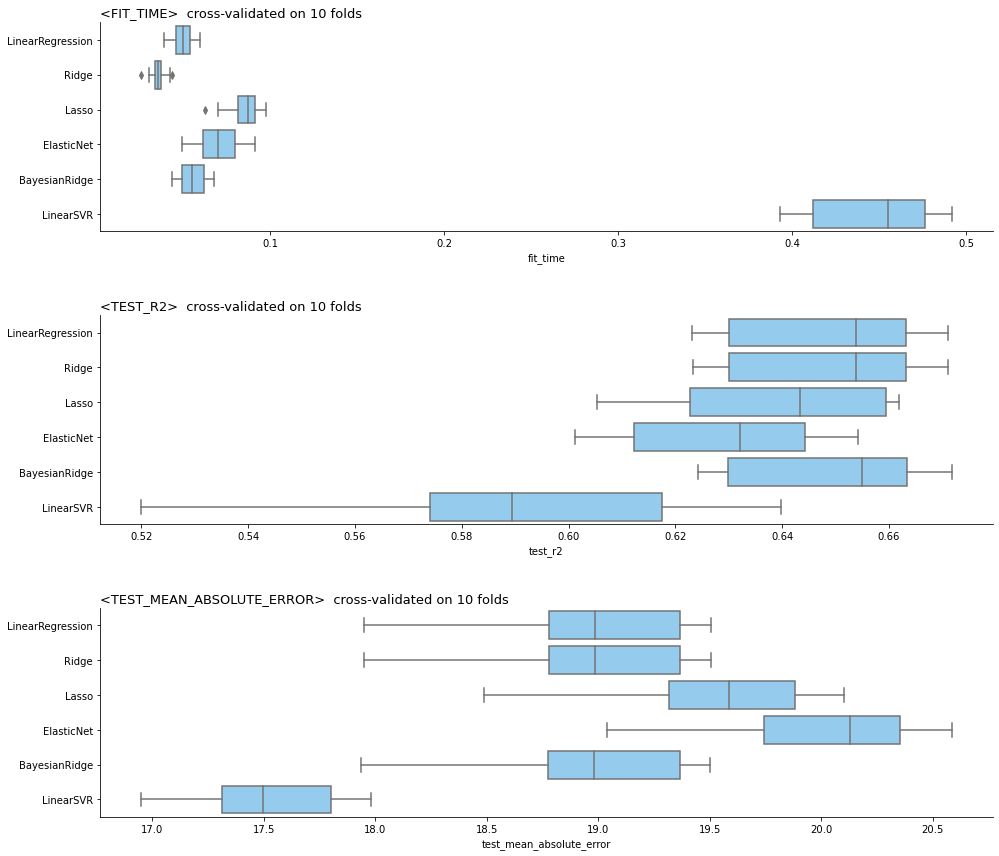

In [5]:
lazy.plot_report(plot_include_time=True)

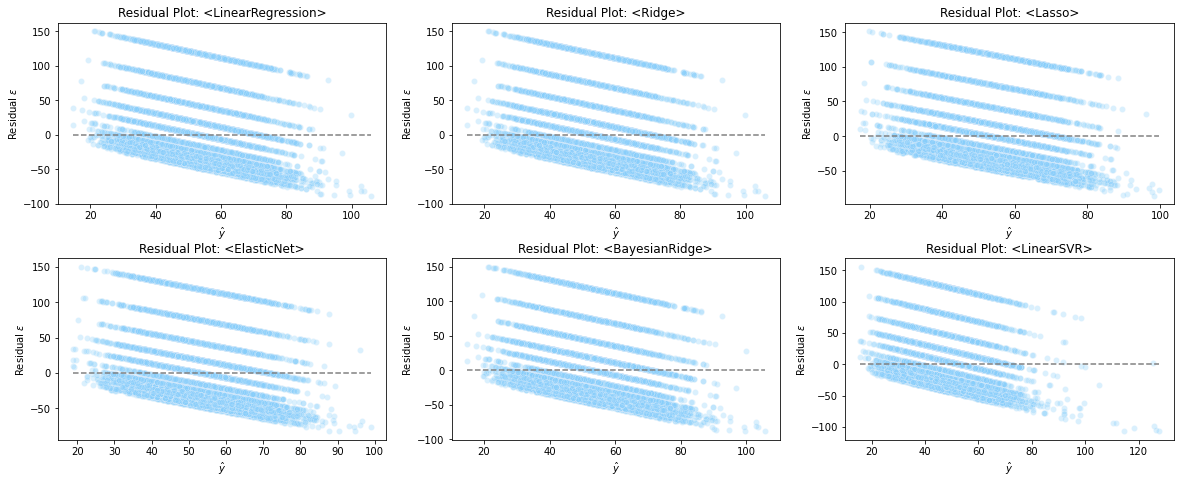

In [6]:
lazy.plot_residuals(data)

## Select Best Feature for Benchmark

In [7]:
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector

In [55]:
best_feature_dict = {}
best_feature_cvscores = {}
for n_features in tqdm(np.arange(1,10+1)):
    select = SequentialFeatureSelector(estimator=LinearRegression(), 
                                       n_features_to_select=n_features, 
                                       direction='forward', 
                                       scoring='neg_mean_squared_error')
    select.fit(X, y)
    best_col = X.columns.to_numpy()[select.get_support()]
    best_feature_dict[n_features] = best_col
    best_feature_cvscores[n_features] = cross_val_score(estimator=Ridge(),
                                                        X=X[best_col], 
                                                        y=y, cv=10, 
                                                        scoring='neg_mean_squared_error')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


In [56]:
tmp = pd.melt(pd.DataFrame.from_dict(best_feature_cvscores), var_name='n_feature', value_name='score')
tmp['score'] = np.abs(tmp['score'])
tmp.head(2)

,n_feature,score
0,1,1117.268909
1,1,1012.932274


In [57]:
tmp_ = tmp.groupby('n_feature').mean()

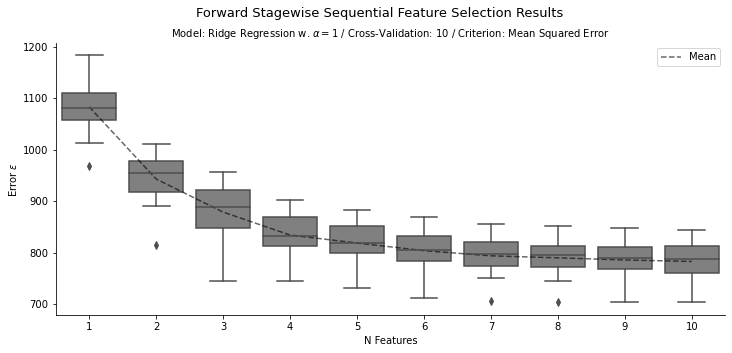

In [58]:
fig = plt.subplots(figsize=(12, 5))
p = sns.boxplot(x=tmp['n_feature'], y=tmp['score'], color='grey')
p1 = sns.lineplot(x=tmp_.index-1, y=tmp_.to_numpy().reshape(-1), color='black', 
                  linestyle='--', label='Mean', alpha=.6)
plt.title(r'Model: Ridge Regression w. $\alpha=1$ / Cross-Validation: 10 / Criterion: Mean Squared Error', fontsize=10)
plt.suptitle('Forward Stagewise Sequential Feature Selection Results', fontsize=13)
plt.xlabel('N Features')
plt.ylabel(r'Error $\epsilon$')
sns.despine()
plt.show()

In [61]:
best_feature_dict[4]

array(['centroid_frequency2_G02', 'centroid_frequency2_M01', 'cv_S01',
       'len_G01'], dtype=object)

In [62]:
X_best = X[best_feature_dict[4]]

## Hyperparameter 

In [63]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [64]:
pipe = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

In [65]:
results = cross_val_score(estimator=pipe, X=X_best, y=np.log(y), cv=10)
print('CV Results:\n', results)
print('Mean Resutls: ', np.mean(results))

CV Results:
 [0.74314205 0.78178684 0.74174916 0.78506051 0.76845615 0.77013783
 0.794851   0.74956447 0.7087861  0.77939143]
Mean Resutls:  0.7622925533384708
